<a href="https://colab.research.google.com/github/ngcaonghi/rl-communicate/blob/master/egg_info_minimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emergence of Language from the Signaling Game with Information Minimization

This final project aims to extract rudimentary prototypes of language, such as vocabulary and grammar, from a multi-agent signaling game inspired by David Lewis (Lewis 1969). 

In this game, 2 deep neural network agents jointly solve an image autoencoding task: the agent acting as the Sender "sees" an image and tries to "describe" it through messages via a discrete communication channel with the one acting as the Receiver; the Receiver then tries to recover that image using those messages. Using a similar set-up but with a heavy architecture for image classification, i.e. VGG-16, and the MS COCO dataset, Havrylov and Titov discovered that the emergent messages bear some resemblance with natural languages that are quite surprising, albeit weak and debatable: they reflect a form of syntax and semantic hierarchy (Havrylov & Titov, 2017). 

Kharitonov et al. also discovered that when the Sender and the Receiver share some prior knowledge, their communication protocol will be optimized by largely ignoring information relevant to such prior knowledge (Kharitonov et al., 2019). However, the jury is still out whether that trick helps with the emergence of natural language prototypes, or whether it in fact sacrifices that emergence for efficiency. My hypothesis is that the former is true.

By playing with the MNIST Dataset and the EGG (Emergence of lanGuage in Games) by Facebook Research, I attempted to address that question and concluded that my hypothesis is unsupported by the data.

## 1. Basic Set-up with MNIST

In this set-up, the Sender and the Receiver both know the images' labels. What they should communicate are the image styles.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install git+https://github.com/facebookresearch/EGG.git

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import egg.core as core

from torchvision import datasets, transforms, models
from torch import utils, save, load
from torch.nn import functional as F

import shutil
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

plt.style.use('dark_background')
opts = core.init(params=['--random_seed=42',
                         '--batch_size=16']) # for reproducibility

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# doubles the labels in each datastream so that one is given to the Receiver
# as mutual information
class RepeatLabel(datasets.MNIST) :
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, torch.tensor(label), torch.tensor(label)

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if opts.cuda else {}
transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
    RepeatLabel('./data', train=True, download=True,
    transform=transform),
    batch_size=opts.batch_size, shuffle=True, **kwargs)


validation_loader = torch.utils.data.DataLoader(
    RepeatLabel('./data', train=False, download=False,
    transform=transform),
    batch_size=4 * opts.batch_size, shuffle=False, **kwargs)

Extracting ./data/RepeatLabel/raw/train-images-idx3-ubyte.gz to ./data/RepeatLabel/raw


Extracting ./data/RepeatLabel/raw/train-labels-idx1-ubyte.gz to ./data/RepeatLabel/raw



Extracting ./data/RepeatLabel/raw/t10k-images-idx3-ubyte.gz to ./data/RepeatLabel/raw


Extracting ./data/RepeatLabel/raw/t10k-labels-idx1-ubyte.gz to ./data/RepeatLabel/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
len(train_loader.dataset.classes)

10

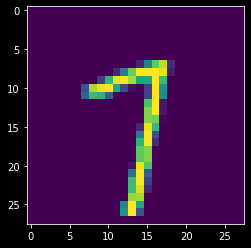

In [ ]:
plt.imshow(train_loader.dataset[42][0].view((28, 28)))

In [ ]:
class Sender(nn.Module):
    ''' Sender architecture: stripped-down LeNet-5 CNN
    with 2 convolutional layers.
    '''
    def __init__(self, vocab_size):
        super(Sender, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, vocab_size)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2), stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2), stride=2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        logits = F.log_softmax(x, dim=1)
        return logits


class Receiver(nn.Module):
    '''Receiver architecture: MLP. Input is prior knowledge, i.e. image labels,
    concatenated with the discrete message from Sender.
    '''
    def __init__(self, vocab_size, class_size):
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(vocab_size, 400)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, 784)
        
        self.class_embedding = torch.nn.Embedding(class_size, 400)

    def forward(self, message, class_label):
        class_embedded = self.class_embedding(class_label)
        message_embedded = self.fc1(message)

        x = torch.cat([message_embedded, class_embedded], dim=1)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)
    
def loss(sender_input, _message, _receiver_input, receiver_output, _labels):
    loss = F.binary_cross_entropy(receiver_output, sender_input.view(-1, 784), reduction='none').mean(dim=1)
    return loss, {}

In [ ]:
hidden_size = 20
embed_size = 10
VOCAB_SIZE = 8
MAX_LEN = 9
TEMP = 0.25 # temperature hyperparameter for Gumbel-Softmax relaxation.
            # The closer the temperature is to 0, the more minimization pressure
            # is imposed on the communication protocol.

# init Sender and Receiver
sender = Sender(hidden_size)
receiver = Receiver(hidden_size, class_size=10)

# wrap them in RNNs with Gumbel-Softmax relaxation
sender_rnn = core.RnnSenderGS(sender, VOCAB_SIZE, embed_size, hidden_size,
                              cell="lstm", max_len=MAX_LEN, temperature=TEMP,
                              trainable_temperature=False)
receiver_rnn = core.RnnReceiverGS(receiver, vocab_size, embed_size,
                    hidden_size, cell="lstm")

# init game
game_rnn = core.SenderReceiverRnnGS(sender_rnn, receiver_rnn, loss)

In [ ]:
# for manually tuning the learning rate of each agent:
optimizer = torch.optim.Adam([
        {'params': game_rnn.sender.parameters(), 'lr': 1e-4},
        {'params': game_rnn.receiver.parameters(), 'lr': 1e-3}
    ])

trainer = core.Trainer(game=game_rnn, optimizer=optimizer, train_data=train_loader,
                       validation_data=validation_loader)
trainer.train(5)

test: epoch 1, loss 0.19623002409934998,  {'mean_length': tensor(3.9917, device='cuda:0')}
test: epoch 2, loss 0.18952509760856628,  {'mean_length': tensor(4.5869, device='cuda:0')}
test: epoch 3, loss 0.1886882483959198,  {'mean_length': tensor(4.6405, device='cuda:0')}
test: epoch 4, loss 0.18621842563152313,  {'mean_length': tensor(4.9761, device='cuda:0')}
test: epoch 5, loss 0.18623371422290802,  {'mean_length': tensor(4.3863, device='cuda:0')}


In [ ]:
# extract messages
sender_input, messages, _receiver_inputs, receiver_outputs, _labels = \
            core.dump_sender_receiver(game_rnn, validation_loader, gs=True, variable_length=True)

In [ ]:
messages[100:110]

[tensor([6, 6, 6, 6, 2, 2, 2, 0], device='cuda:0'),
 tensor([6, 6, 6, 2, 2, 2, 0], device='cuda:0'),
 tensor([6, 2, 2, 0], device='cuda:0'),
 tensor([6, 6, 6, 6, 6, 2, 2, 2, 0], device='cuda:0'),
 tensor([6, 6, 6, 6, 6, 6, 6, 6, 0], device='cuda:0'),
 tensor([6, 6, 6, 2, 2, 0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([2, 2, 0], device='cuda:0'),
 tensor([6, 6, 2, 2, 2, 0], device='cuda:0'),
 tensor([6, 6, 2, 2, 0], device='cuda:0')]

In [ ]:
def tensor_to_string(t) :
    s = ''
    t = t.to('cpu').numpy()
    for i in t :
        s += str(i)
    return s

messages_to_strings = [tensor_to_string(message) for message in messages]

In [ ]:
message_code = np.unique(messages_to_strings)
message_code

array(['0', '20', '220', '2220', '240', '40', '440', '620', '6220',
       '62220', '6240', '640', '6440', '64440', '644440', '646662220',
       '6620', '66220', '662220', '6640', '66420', '664240', '66440',
       '664440', '6644440', '664444440', '66620', '666220', '6662220',
       '66622220', '666420', '6664220', '6664240', '6666220', '66662220',
       '666622220', '666662220', '666666220', '666666620', '666666660'],
      dtype='<U9')

In [ ]:
len(message_code)
# looks like with this set-up, the 2 agents came up with 40 "words" to describe 
# the image styles in the validation dataset

40

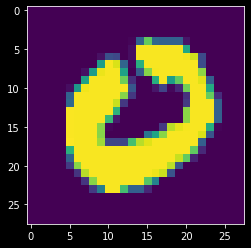

In [ ]:
plt.imshow(validation_loader.dataset[25][0].view(28, 28))

In [ ]:
fours_idx_list = []
for code in message_code :
    for i, message in enumerate(messages_to_strings) :
        if (_labels[i].to('cpu') == torch.tensor(4)) and (message == code) :
            fours_idx_list.append(i)
            break

In [ ]:
len(fours_idx_list)
# looks like number 4 in the validation set is written in 31 different styles, according to the agents

31

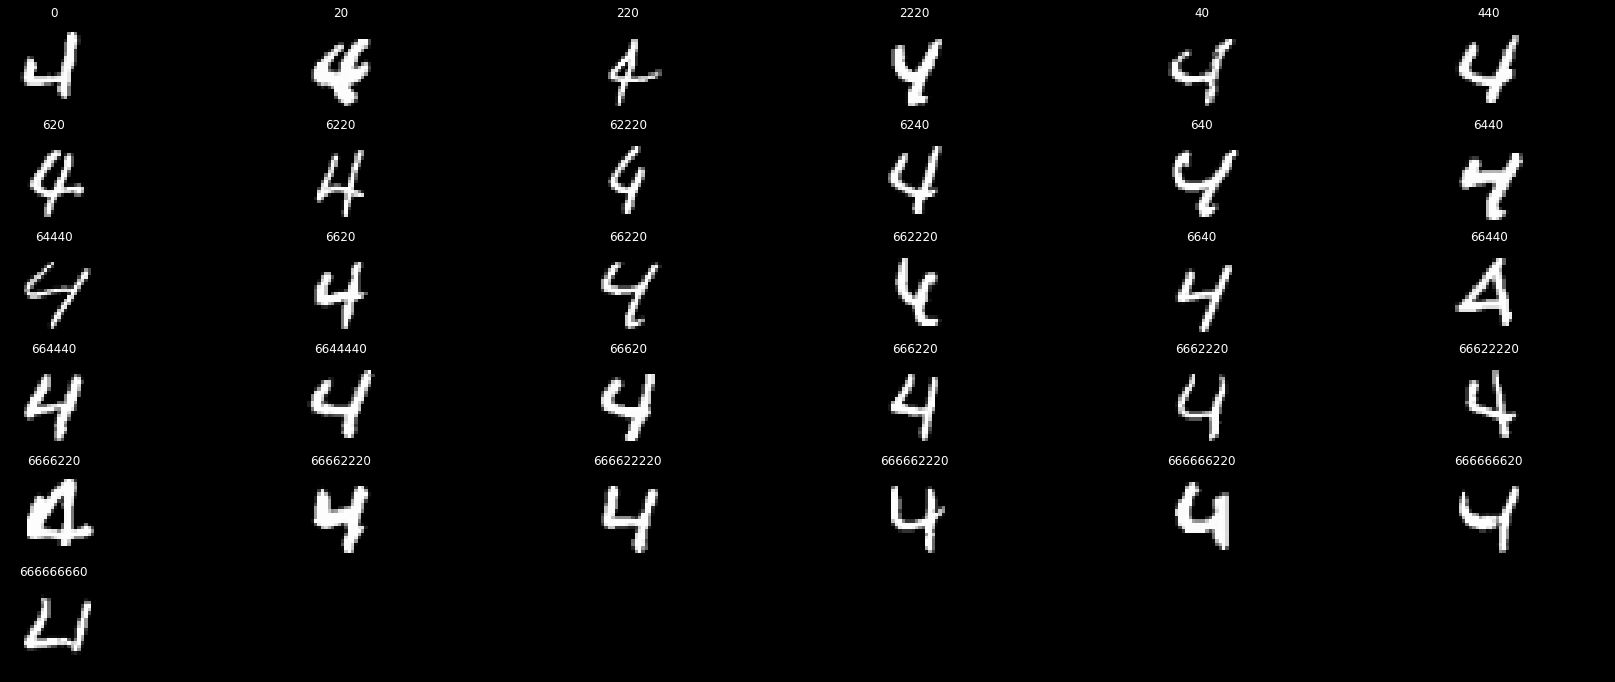

In [ ]:
f, ax = plt.subplots(6, 6, figsize=(30, 12))

for i, index in enumerate(fours_idx_list) :
    image = validation_loader.dataset[index][0].view(28, 28)
    ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(messages_to_strings[index])
    ax[i//6][i%6].axis('off')

for i in range(31, 36) :
    ax[i//6][i%6].axis('off')

Seems like the semantic or syntactic hierarchy is not very intelligible in this case. Let's play with another set-up, in which the agents share a kind of knowledge that very much belongs to human common sense: even and odd numbers.

## Basic Set-up 2: MNIST with Asymmetrical Prior Knowledge

My hypothesis is that with an asymmetry of knowledge between the 2 agents, their messages should account for that fact. In other words, it should be reflected in some emergent form of *meaning*.

In [ ]:
class WithOddness(datasets.MNIST) :
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        oddness = 0
        if label % 2 == 1:
            oddness = 1
        return image, torch.tensor(label), torch.tensor(oddness)

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if opts.cuda else {}
transform = transforms.ToTensor()

train_loader_2 = torch.utils.data.DataLoader(
    WithOddness('./data', train=True, download=True,
    transform=transform),
    batch_size=opts.batch_size, shuffle=True, **kwargs)


validation_loader_2 = torch.utils.data.DataLoader(
    WithOddness('./data', train=False, download=False,
    transform=transform),
    batch_size=4 * opts.batch_size, shuffle=False, **kwargs)

Extracting ./data/WithOddness/raw/train-images-idx3-ubyte.gz to ./data/WithOddness/raw


Extracting ./data/WithOddness/raw/train-labels-idx1-ubyte.gz to ./data/WithOddness/raw


Extracting ./data/WithOddness/raw/t10k-images-idx3-ubyte.gz to ./data/WithOddness/raw


Extracting ./data/WithOddness/raw/t10k-labels-idx1-ubyte.gz to ./data/WithOddness/raw
Processing...
Done!


In [ ]:
hidden_size = 20
embed_size_sender = 10
embed_size_receiver = 2

VOCAB_SIZE = 8
MAX_LEN = 9
TEMP = 0.25 

# init Sender and Receiver
sender = Sender(hidden_size)
receiver = Receiver(hidden_size, class_size=2)

# wrap them in RNNs with Gumbel-Softmax relaxation
sender_rnn = core.RnnSenderGS(sender, VOCAB_SIZE, embed_size_sender, hidden_size,
                              cell="lstm", max_len=MAX_LEN, temperature=TEMP,
                              trainable_temperature=False)
receiver_rnn = core.RnnReceiverGS(receiver, VOCAB_SIZE, embed_size_receiver,
                    hidden_size, cell="lstm")

# init game
game_rnn = core.SenderReceiverRnnGS(sender_rnn, receiver_rnn, loss)

In [ ]:
optimizer = torch.optim.Adam([
        {'params': game_rnn.sender.parameters(), 'lr': 1e-4},
        {'params': game_rnn.receiver.parameters(), 'lr': 1e-3}
    ])

trainer = core.Trainer(game=game_rnn, optimizer=optimizer, train_data=train_loader_2,
                       validation_data=validation_loader_2)
trainer.train(5)

test: epoch 1, loss 0.2287134826183319,  {'mean_length': tensor(5.4077, device='cuda:0')}
test: epoch 2, loss 0.21820184588432312,  {'mean_length': tensor(5.1605, device='cuda:0')}
test: epoch 3, loss 0.21607866883277893,  {'mean_length': tensor(5.4261, device='cuda:0')}
test: epoch 4, loss 0.21297360956668854,  {'mean_length': tensor(5.2055, device='cuda:0')}
test: epoch 5, loss 0.21413613855838776,  {'mean_length': tensor(4.4505, device='cuda:0')}


In [ ]:
sender_input, messages, _receiver_inputs, receiver_outputs, _labels = \
            core.dump_sender_receiver(game_rnn, validation_loader_2, gs=True, variable_length=True)
messages[100:110]

[tensor([4, 4, 1, 1, 1, 1, 0], device='cuda:0'),
 tensor([4, 4, 4, 4, 1, 1, 1, 0], device='cuda:0'),
 tensor([4, 4, 4, 4, 1, 1, 0], device='cuda:0'),
 tensor([4, 4, 1, 1, 0], device='cuda:0'),
 tensor([4, 4, 1, 1, 1, 0], device='cuda:0'),
 tensor([4, 4, 1, 1, 0], device='cuda:0'),
 tensor([4, 4, 4, 1, 1, 1, 0], device='cuda:0'),
 tensor([7, 0], device='cuda:0'),
 tensor([4, 4, 1, 1, 0], device='cuda:0'),
 tensor([4, 1, 1, 0], device='cuda:0')]

In [ ]:
messages_to_strings_2 = [tensor_to_string(message) for message in messages]
message_code_2 = np.unique(messages_to_strings_2)
message_code_2

array(['0', '10', '110', '1110', '170', '40', '410', '4110', '41110',
       '411110', '411130', '41170', '4170', '440', '4410', '44110',
       '441110', '4411110', '4411130', '441130', '44130', '4430', '4440',
       '44410', '444110', '4441110', '44411110', '44411130', '4441130',
       '444130', '44430', '44440', '444410', '4444110', '44441110',
       '444411130', '44441130', '4444410', '44444110', '444441110',
       '444441130', '44444410', '444444110', '444444130', '44444430',
       '444444410', '444444440', '470', '70'], dtype='<U9')

In [ ]:
len(message_code_2)

49

In [ ]:
fours_idx_list_2 = []
for code in message_code_2 :
    for i, message in enumerate(messages_to_strings_2) :
        if (_labels[i].to('cpu') == torch.tensor(4)) and (message == code) :
            fours_idx_list_2.append(i)
            break

len(fours_idx_list_2)

16

In [ ]:
sevens_idx_list_2 = []
for code in message_code_2 :
    for i, message in enumerate(messages_to_strings_2) :
        if (_labels[i].to('cpu') == torch.tensor(7)) and (message == code) :
            sevens_idx_list_2.append(i)
            break

len(sevens_idx_list_2)

15

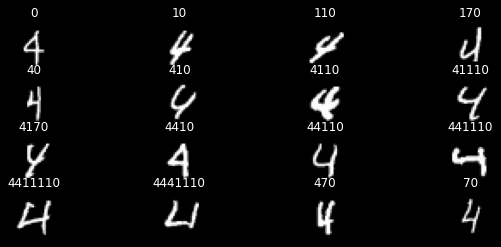

In [ ]:
f, ax = plt.subplots(4, 4, figsize=(10, 4))

for i, index in enumerate(fours_idx_list_2) :
    image = validation_loader_2.dataset[index][0].view(28, 28)
    ax[i//4][i%4].imshow(image, cmap='gray')
    ax[i//4][i%4].set_title(messages_to_strings_2[index])
    ax[i//4][i%4].axis('off')

(0.0, 1.0, 0.0, 1.0)

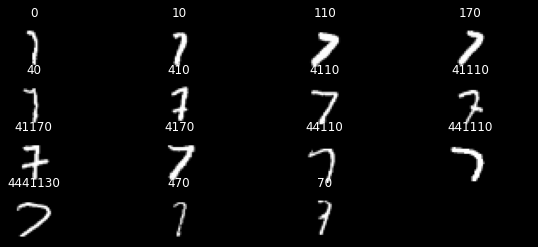

In [ ]:
f, ax = plt.subplots(4, 4, figsize=(10, 4))

for i, index in enumerate(sevens_idx_list_2) :
    image = validation_loader_2.dataset[index][0].view(28, 28)
    ax[i//4][i%4].imshow(image, cmap='gray')
    ax[i//4][i%4].set_title(messages_to_strings_2[index])
    ax[i//4][i%4].axis('off')

ax[3][3].axis('off')

In [ ]:
data = {
    'Oddness' : _labels,
    'Messages' : messages_to_strings_2
}

df = pd.DataFrame(data, columns=['Oddness', 'Messages'])
df.head()

,Oddness,Messages
0,tensor(7),4110
1,tensor(2),4411110
2,tensor(1),70
3,tensor(0),44441110
4,tensor(4),44110


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Oddness   10000 non-null  object
 1   Messages  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
message_idx = range(len(message_code_2))
message_categories = dict(zip(message_code_2, message_idx))

In [ ]:
df['Messages'] = df['Messages'].apply(lambda x: message_categories[x])
df['Oddness'] = df['Oddness'].apply(lambda x: 0 if x % 2 == torch.tensor(0) else 1)
df.head()

,Oddness,Messages
0,1,7
1,0,17
2,1,48
3,0,34
4,0,15


In [ ]:
df.corr()

,Oddness,Messages
Oddness,1.000000,0.045609
Messages,0.045609,1.000000


Uh oh, the Pearson Correlation **r** is too small for n = 10000. Looks like my hypothesis was not supported.
